# Titanic Data Analysis in Python
                         

*This analysis is served for the purpose of passing the course project of intro to data analysis in the Udacity Nanodegree of Data Analyst *

*2017.7.5*

## 1. Introduction

This notebook demonstates an introductory data analysis of titanic dataset, espeically focused on 1-D and 2-D data visulization. It also includes some data preprocessing, feature engineering and statistical testing. The main purpose of this notebook is to see the charactristics of variables in the dataset and identify which group of people have more chance to survive the shipwreck. 

The data preprocessing is inspired by the [Titanic best working Classifier](https://www.kaggle.com/sinakhorami/titanic-best-working-classifier)



Load moduales and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# set plot color for dark theme
from jupyterthemes import jtplot
jtplot.style()

In [303]:
titanic = pd.read_csv('train.csv', header = 0, dtype={'Age': np.float64})
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [305]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [306]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Quick view after loading the data, we see 2 numerical variables, Fare and Age. 3 text string variables Ticket, Cabin, and Name. The others are categorical variables, Plcass, SibSp, Parch, Sex, Embarked and Survived. Since we are extremely interested in the survival. Variable 'Survived' no doubt will be our dependent variable.

## 2. Data Preprocessing

 ####  New Variables

First we create some new variables so we can dive deep into the characteristics of the data and better understand the passengers. Most of passenger names in the dataset have title. We get the title out of the name and make a new variable 'Title' for future group analysis. "Sibsp" and "Parch" include the information about the number of kids, parents, and siblings for each passenger. Since they all from the perspective of passenger's family, we create variable 'FamilySize' to comprehend all the information. 

In [308]:
# Get the Title from the Name
import re
def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""
titanic['Title'] = titanic['Name'].apply(get_title)


In [310]:
# format the title
titanic['Title'] = titanic['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic['Title'] = titanic['Title'].replace('Mlle', 'Miss')
titanic['Title'] = titanic['Title'].replace('Ms', 'Miss')
titanic['Title'] = titanic['Title'].replace('Mme', 'Mrs')
print(pd.crosstab(titanic['Title'], titanic['Sex']))
titles = titanic.Title.unique()

Sex     female  male
Title               
Master       0    40
Miss       185     0
Mr           0   517
Mrs        126     0
Rare         3    20


In [311]:
# Create FamilySize feature and feature IsAlone. IsAlone = 1 when FamilySize = 1
titanic['FamilySize'] = 1 + titanic['SibSp'] + titanic['Parch']
titanic['isAlone'] = 0
titanic.loc[titanic.FamilySize == 1, 'isAlone'] = 1

#### Handling Missing Values

Check missing values for each feature.

In [372]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Title            0
FamilySize       0
isAlone          0
dtype: int64

Variable 'Cabin' has the most occurences of NA value. Since cabin is just the serial number, it is not necessary to impute. There are lots of missing valus existed in 'Age'. We generate numbers from between (mean - std) and (mean + std) to impute. We only have two missing values in Embarked, median imputation will be applied. For the clarification, we check the characteristics of age distribution first then decide the method to impute the age.

In [256]:
# Age imputation
def impute_age(data, title):
    imputeData = data[data.Title == title].Age
    ageMean = imputeData.mean()
    ageStd = imputeData.std()
    size = imputeData.isnull().sum()
    imputeNA = np.random.randint(ageMean - ageStd, ageMean + ageStd, size=size)
    #data[data.Title == title].Age[nullIndex] = impute_data
    imputeData.loc[imputeData.isnull()]= imputeNA
    #data['Age'] = data['Age'].astype(int)
    data.loc[data.Title == title, 'Age'] = imputeData
    return data

In [324]:
for title in titles:
    impute_age(titanic, title)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [325]:
titanic.Age.isnull().sum()

0

In [326]:
# Embarked Imputation
mode = titanic.Embarked.mode()
titanic['Embarked'].fillna(mode[0], inplace=True)

In [327]:
print 'Embarked # of missing values: ', train.Embarked.isnull().sum()

Embarked # of missing values:  0


#### Feature Formatting

In [395]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null object
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null int64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
Title          891 non-null object
FamilySize     891 non-null int64
isAlone        891 non-null object
dtypes: float64(1), int64(6), object(8)
memory usage: 104.5+ KB


In [407]:
titanic.Pclass = titanic.Pclass.astype(object)
titanic.Age = titanic.Age.astype(int)
titanic.isAlone = titanic.isAlone.astype(object)

## 3. Data Exploration

After making the data clean, we are ready to explore all the interested variables. Like, How many people survived the shipwreck? Are kids more likely to survive? etc. First, we will peform univariate analysis and then explore the relationship between 'Survived' and other variables using multivariate analysis. Last, we will use some statistical testing to examine our hypothesis. 

####  Univariate Analysis

In [363]:

def uni_cate_plot(data, feature):
    fig, ax = plt.subplots()
    ax = sns.stripplot(x = data[feature].value_counts().index, 
                       y = data[feature].value_counts()/len(data))
    plt.xlabel(feature)
    plt.ylabel('Rate')
    print  data[feature].value_counts()
    print data[feature].value_counts() / len(data)
    
    

0    549
1    342
Name: Survived, dtype: int64
0    0.616162
1    0.383838
Name: Survived, dtype: float64


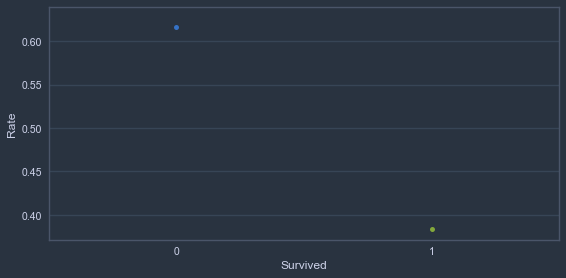

In [364]:
uni_cate_plot(titanic, 'Survived')

38.3% of passengers survived the tradegy, which means the dataset is pretty skewed.


3    491
1    216
2    184
Name: Pclass, dtype: int64
3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64


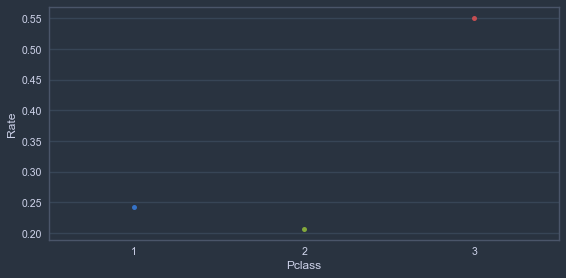

In [365]:
uni_cate_plot(titanic, 'Pclass')

Among all the passengers, 24.2% of passengers are first class, 20.7% are second class and 55% are third class.


male      577
female    314
Name: Sex, dtype: int64
male      0.647587
female    0.352413
Name: Sex, dtype: float64


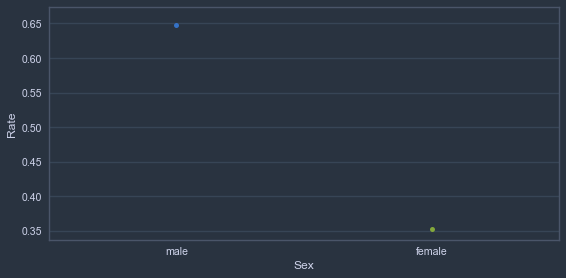

In [366]:
uni_cate_plot(titanic, 'Sex')

Male passengers: 64.8%
    
Female passengers: 35.2%

S    646
C    168
Q     77
Name: Embarked, dtype: int64
S    0.725028
C    0.188552
Q    0.086420
Name: Embarked, dtype: float64


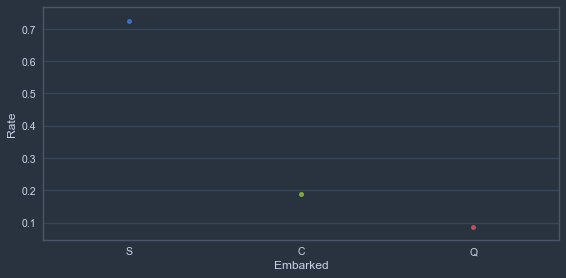

In [367]:
uni_cate_plot(titanic, 'Embarked')

C = Cherbourg, Q = Queenstown, S = Southampton

Embarkation Port for Sourthhampton, Queenstown, Cherbourg: 72.5%, 18.9%, 8.6%


1    537
0    354
Name: isAlone, dtype: int64
1    0.602694
0    0.397306
Name: isAlone, dtype: float64


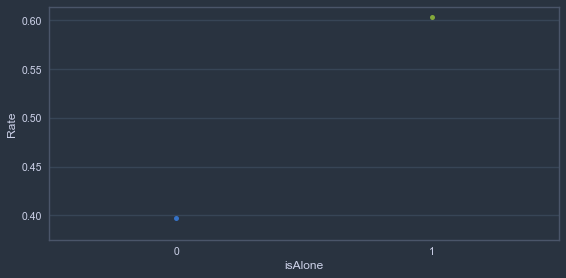

In [368]:
uni_cate_plot(titanic, 'isAlone')

40% of passengers are alone on this trip

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64
Mr        0.580247
Miss      0.207632
Mrs       0.141414
Master    0.044893
Rare      0.025814
Name: Title, dtype: float64


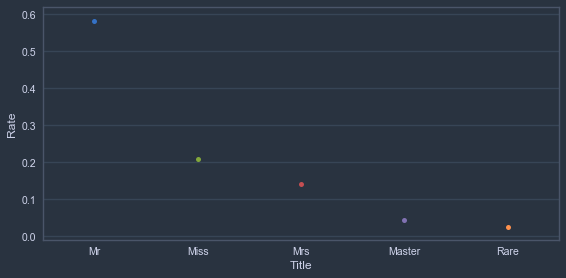

In [369]:
uni_cate_plot(titanic, 'Title')

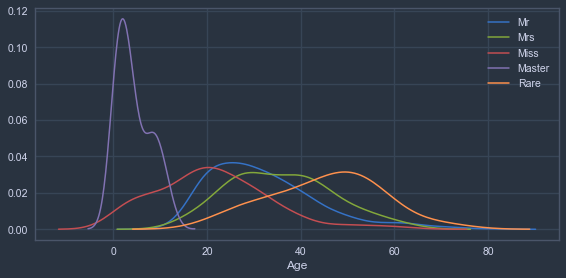

In [339]:
# Kenel Density Estimation 
for title in titles:   
    ax = sns.distplot(titanic[titanic.Title == title].Age, hist=False, label = title)
plt.legend()

count    891.000000
mean      29.386274
std       13.763070
min        0.000000
25%       21.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


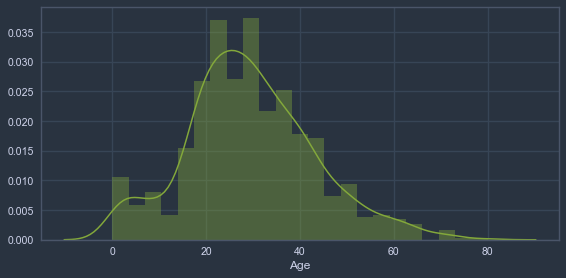

In [340]:
ax = sns.distplot(titanic.Age, color="g")
print titanic.Age.describe()

Some interesting findings from the plots above are :

(1) Age distribution approximately follows a normal distritbion except for a bump on its left tail.

(2) Mean and standard deviation for the age are 30 and 13.5. 75% passengers are younger 37.

(3) 'Master' group are mostly under 10 years old and accounts for 4.4% of the total travellers.  



count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


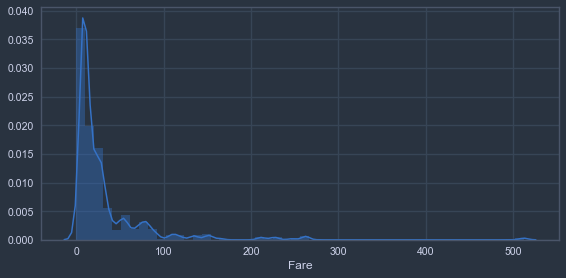

In [342]:
ax = sns.distplot(titanic.Fare)
print titanic.Fare.describe()

Fare distribution looks like following a Pareto distribution. 75% fare is less than $31

In [347]:
familysizeCount = pd.DataFrame({'Counts' : titanic.FamilySize.value_counts()})
familysizeCount['Ratio'] = familysizeCount / len(titanic)
familysizeCount

,Counts,Ratio
1,537,0.602694
2,161,0.180696
3,102,0.114478
4,29,0.032548
6,22,0.024691
5,15,0.016835
7,12,0.013468
11,7,0.007856
8,6,0.006734


1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64
1     0.602694
2     0.180696
3     0.114478
4     0.032548
6     0.024691
5     0.016835
7     0.013468
11    0.007856
8     0.006734
Name: FamilySize, dtype: float64


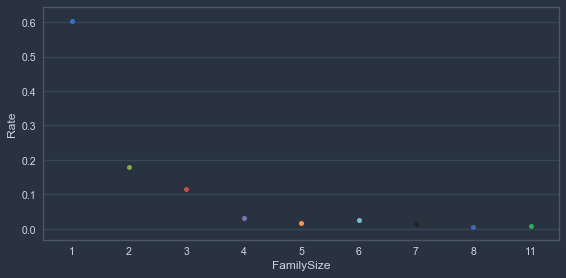

In [370]:
uni_cate_plot(titanic, 'FamilySize')

60% of passengers was travelling on their own.

#### Multivariate Analysis

In [375]:
titanic.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked', u'Title',
       u'FamilySize', u'isAlone'],
      dtype='object')

Who survived this shipwreck and what are their identities? In this part, we will explore the quantitative relationship between dependent variable, 'Survived', and the other variables.

In [373]:
def feature_weight(data, feature):
    return data[[feature, 'Survived']].groupby(feature, as_index=False).mean()
    

In [374]:
feature_weight(titanic, 'Pclass')

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


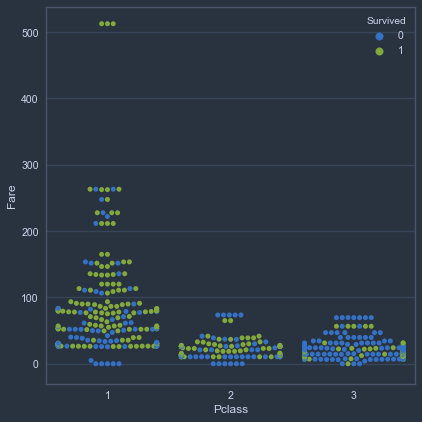

In [533]:
# Plots with feature 'Pclass', 'Fare', and 'Survived'
plt.figure(figsize=(6, 6))
ax = sns.swarmplot(x="Pclass", y="Fare", data=titanic, hue="Survived")


count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

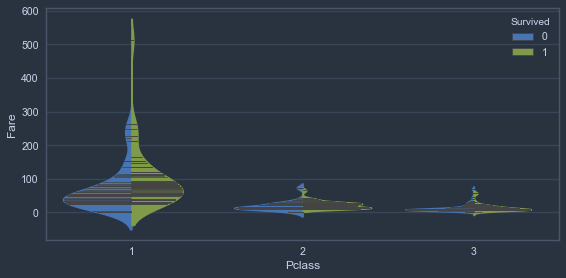

In [537]:
sns.violinplot(x="Pclass", y="Fare", hue="Survived", data=titanic, split=True, inner="stick")

In [377]:
titanic[titanic.Fare > 500]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,isAlone
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,Miss,1,1
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,Mr,2,0
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,Mr,1,1


Does higer social status have more chance to find a seat in the lifeboat? The answer might be yes.
According to the table and plot above, we can see 1st Class > 2nd Class > 3rd Class. And the highest fare tickets(>500) holders in the first class are all survived. One interesting thing is that a higher class ticket does not mean a higher cost ('Fare') but a passenger with higher fare are more likely to survive.

In [381]:
feature_weight(titanic, 'Sex')

,Sex,Survived
0,female,0.742038
1,male,0.188908


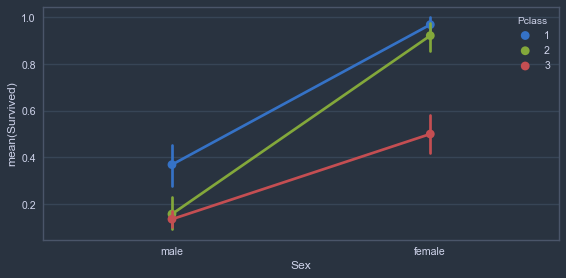

In [382]:
sns.pointplot(x="Sex", y="Survived", hue="Pclass", data=titanic);

Female survival rate much larger than male, especially for 1st and 2nd classes, more than 85%

In [383]:
feature_weight(titanic, 'FamilySize')

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [293]:
plotFamilysize = feature_weight(train, 'FamilySize')
plotFamilysize['isAlone'] = False
plotFamilysize.loc[0, 'isAlone'] = True

,FamilySize,Survived,isAlone
0,1,0.303538,True
1,2,0.552795,False
2,3,0.578431,False
3,4,0.724138,False
4,5,0.200000,False
5,6,0.136364,False
6,7,0.333333,False
7,8,0.000000,False
8,11,0.000000,False


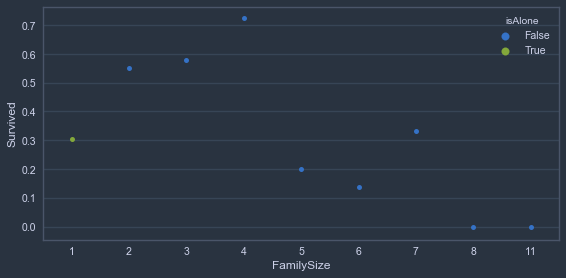

In [294]:
sns.stripplot(x="FamilySize", y="Survived", data=plotFamilysize, hue='isAlone')

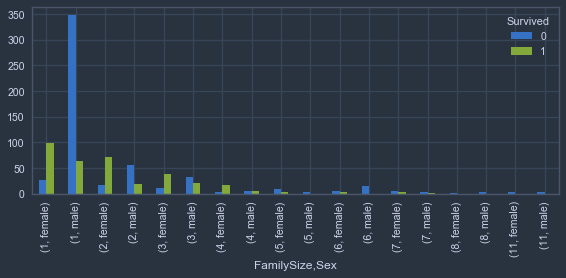

In [295]:
train.groupby(['FamilySize', 'Survived', 'Sex']).size().unstack('Survived').plot(kind = 'bar')

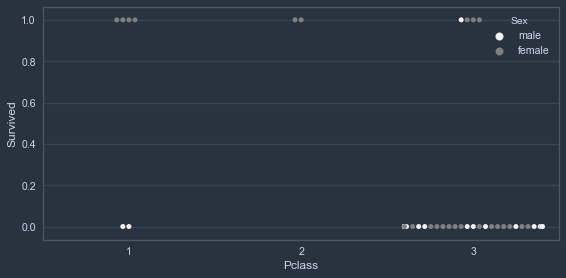

In [408]:
ax = sns.swarmplot(x="Pclass", y="Survived", 
                   data=titanic[titanic.FamilySize>4], 
                   hue="Sex", color='0.5')


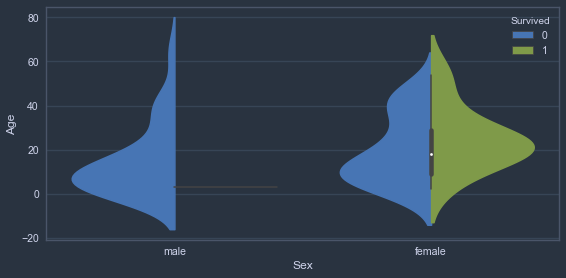

In [418]:
sns.violinplot(x="Sex", y="Age", hue="Survived", data=titanic[titanic.FamilySize>4], split=True);

'Bachelors' on the Titanic are not likely(30%) to survive the titanic. Sadly, Lots of the kids of big family('FamilySize'>4) were failed to survive.

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


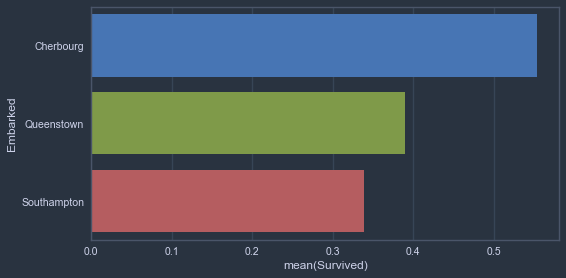

In [499]:

em_plot = feature_weight(titanic, 'Embarked')
ax = sns.barplot(x="Survived", y="Embarked", data=em_plot)
plt.yticks(xrange(3),('Cherbourg', 'Queenstown', 'Southampton'))
print em_plot

Embarked at Cherbourg has higher survival rate 55.3%

In [297]:
feature_weight(train, 'Title')

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


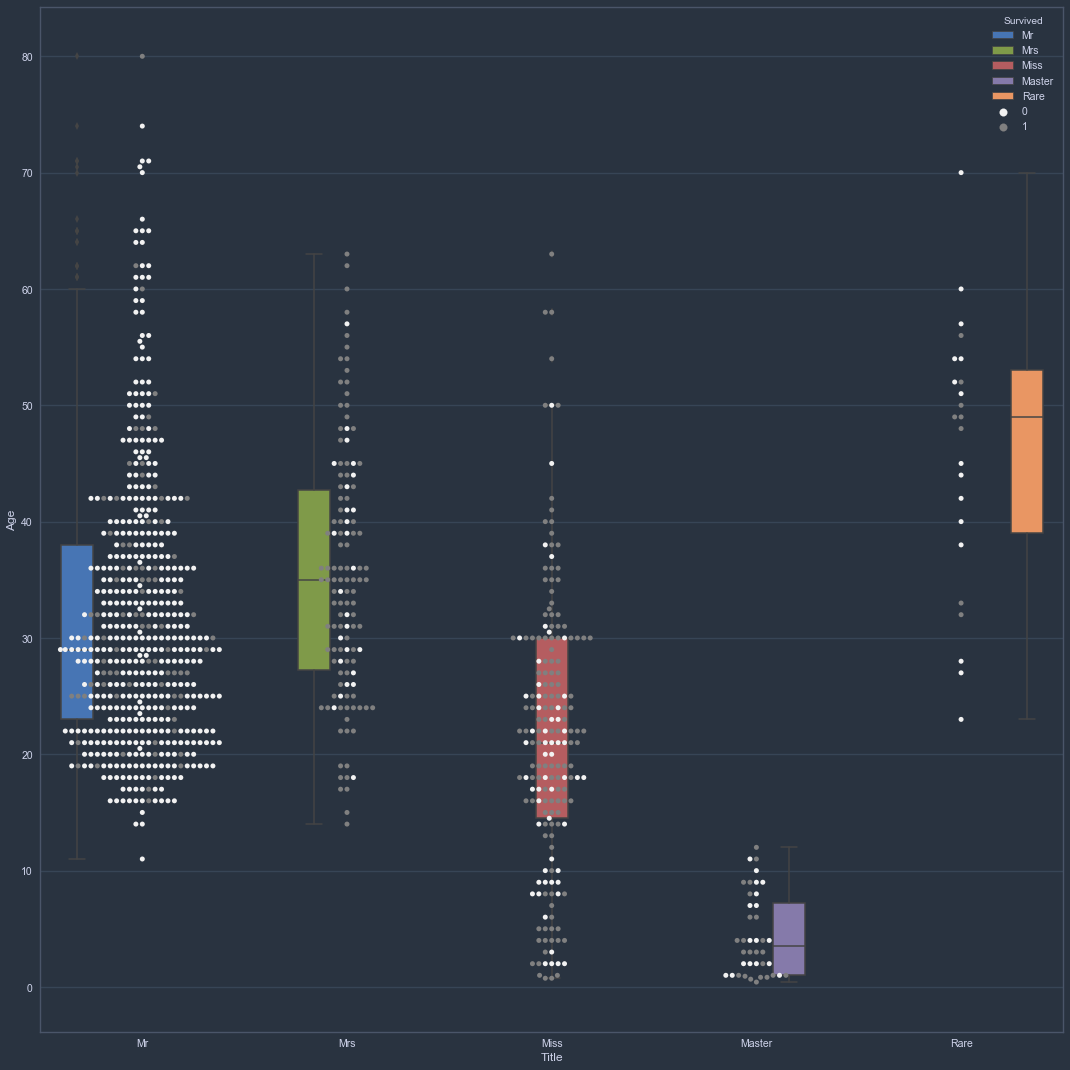

In [300]:
plt.figure(figsize=(15,15))
ax = sns.boxplot(x="Title", y="Age", hue="Title", data=train)
ax = sns.swarmplot(x="Title", y="Age", data=train, hue="Survived", color='0.5')


Again female('Mrs' and 'Miss') have a better chance to survive than other groups. Children (Master) are also more likely to escape this tradegy, 57.5% 

#### Further  Exploration

From multivariate analysis, we have seen some factors that lead to higher chance of survival, such as feamale, upperclass, or Embarkation. There is no doubt that women and children are our priority when comes to the emergency rescue. What is surprising is that people embarked at Cherbourg has higher survival rate than other ports of embrakation(Queebstown and Southampton). So we are going to further explore causing reasons. 

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009

**Titanic Maiden Voyage**
![alt text](http://www.titanicfacts.net/images/titanic-maiden-voyage.gif)

In [521]:
titanic.groupby(['Embarked','Pclass']).mean().Survived

Embarked  Pclass
C         1         0.694118
          2         0.529412
          3         0.378788
Q         1         0.500000
          2         0.666667
          3         0.375000
S         1         0.589147
          2         0.463415
          3         0.189802
Name: Survived, dtype: float64

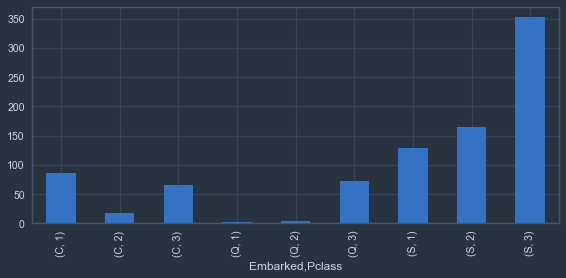

In [519]:
titanic.groupby(['Embarked','Pclass']).size().plot('bar')

In [517]:
titanic.groupby(['Embarked','Sex']).mean().Survived

Embarked  Sex   
C         female    0.876712
          male      0.305263
Q         female    0.750000
          male      0.073171
S         female    0.692683
          male      0.174603
Name: Survived, dtype: float64

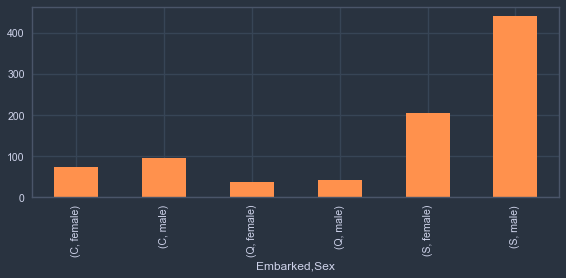

In [513]:
titanic.groupby(['Embarked','Sex']).size().plot('bar', color='y')

From the plots above, we can see that the high pecentage of 1st class survival rate in Cherbourg group increase its total survival rate. The big population in Southampton, especially in 3rd class group, drag down its total survival rate. But whether there is any relationship between 'Pclass' and 'Embarked'? We use chi-squre test to perform the check.

In [532]:
observed = pd.crosstab(titanic.Embarked, titanic.Pclass)
observed

Pclass,1,2,3
Embarked,,,
C,85,17,66
Q,2,3,72
S,129,164,353


H0: There is no significant relationship between 'Pclass' and 'Embarked'.

H1: There is a significant relationship between 'Pclass' and 'Embarked'.

In [531]:
import scipy.stats as stats
stats.chi2_contingency(observed= observed)


(122.64116372971472,
 1.4569383279917686e-25,
 4,
 array([[  40.72727273,   34.69360269,   92.57912458],
        [  18.66666667,   15.90123457,   42.43209877],
        [ 156.60606061,  133.40516274,  355.98877666]]))

P-value(1.45e-25) is far less than 0.05, which means there exists a strong relationship between 'Pclass' and 'Embarked'. The passengers embarked at different ports are having different class distribution.

## Conclusions

Through the data visualization, we managed to find some interesting knowledge:

(1) Female passengers were having more chance(74.2%) to survive the shipwreck.

(2) Passengers in the first class and second were more likely to escape the disaster. 

(3) Sole passengers were more likely to die but lots of the kids in big family('FamilySize'>4) were failed to survive.

(4) Passengers embarked at Cherbourg have higher possibility to be alive than other group, becauses it has higher percentage of 1st class passegners.

(5) The fare cost of second class and third class were on same level, but the second class passengers had higher survival rate than the third class passengers. The fare cost of the first class had a larger range, from 0 to more than 500. 

